In [1]:
import tensorflow as tf
import numpy as np
import sionna as sn
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Model
import importlib
import PA_model
importlib.reload(PA_model)
from PA_model import PAModel, ACPRCalculatorTF
import matplotlib.pyplot as plt

2026-02-17 16:47:45.011442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771339665.023765   27989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771339665.027903   27989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771339665.037149   27989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771339665.037163   27989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771339665.037164   27989 computation_placer.cc:177] computation placer alr

In [10]:

class Modulator(Layer):

    def __init__(self, constellation, **kwargs):
        super(Modulator,self).__init__(**kwargs)

        # Define the real and imaginary parts of the constellation as trainable variables
        # self.constellation_real = tf.Variable(constellation.real, dtype=tf.float32, trainable=True)
        # self.constellation_imag = tf.Variable(constellation.imag, dtype=tf.float32, trainable=True)

        self.constellation_real_init = constellation.real
        self.constellation_imag_init = constellation.imag

    def build(self, input_shape):
        self.constellation_real = self.add_weight(
            name="constellation_real",
            shape=self.constellation_real_init.shape,
            initializer=tf.constant_initializer(self.constellation_real_init),
            trainable=True
        )
        self.constellation_imag = self.add_weight(
            name="constellation_imag",
            shape=self.constellation_imag_init.shape,
            initializer=tf.constant_initializer(self.constellation_imag_init),
            trainable=True
        )

    def call(self, s):
        # Combine the real and imaginary parts into a complex-valued constellation
        constellation_combined = tf.complex(self.constellation_real, self.constellation_imag)

        # Expand the signal dimension to align for matrix multiplication
        s = tf.expand_dims(s, axis=-1)

        # Calculate the normalization constant
        normalization_constant = tf.sqrt(
            tf.reduce_mean(tf.abs(constellation_combined) ** 2)
        )

        normalization_constant = tf.complex(normalization_constant,0.0)

        # Normalize the constellation
        norm_constellation = tf.expand_dims(constellation_combined, axis=0)  # Add batch dimension
        norm_constellation = norm_constellation / normalization_constant
        norm_constellation = tf.expand_dims(norm_constellation, axis=0)  # Expand further for batch processing

        # print('norm_constellation:', norm_constellation.shape)

        # Compute the modulated signal
        x_real = tf.matmul(tf.math.real(norm_constellation), s)
        x_imag = tf.matmul(tf.math.imag(norm_constellation), s)
        x = tf.complex(x_real, x_imag)

        return tf.squeeze(x, axis=[-2, -1])

class Demodulator(Layer):
    def __init__(self, N, snr_db):
        super(Demodulator, self).__init__()
        self.dense1 = Dense(128, activation='relu')  # First Dense Layer
        self.dense2 = Dense(128, activation='relu')  # Second Dense Layer
        self.dense3 = Dense(N)                      # Output Dense Layer
        self.snr_db = snr_db                        # SNR in dB
        # self.device = device                        # Device (e.g., "cpu", "gpu")

    def call(self, y):
        # Ensure complex-valued input is split into real and imaginary parts
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)

        # Create and broadcast SNR tensor
        snr_tensor = tf.constant([[self.snr_db]], dtype=tf.float32)
        brd_snr_tensor = tf.broadcast_to(snr_tensor, [tf.shape(y_real)[0], 1])

        # Concatenate real, imaginary, and SNR tensors along the last dimension
        stack_input = tf.concat([y_real, y_imag, brd_snr_tensor], axis=1)

        ## print('brd_snr_tensor.shape: ',brd_snr_tensor)

        # Pass the stacked input through the dense layers
        x = self.dense1(stack_input)
        x = self.dense2(x)
        logits = self.dense3(x)

        # Apply softmax to logits
        pred_probs = tf.nn.softmax(logits, axis=-1)

        return pred_probs

class AWGNDemodulator(Layer):
    def __init__(self, constellation, N0, **kwargs):
        super().__init__(**kwargs)

        # Store constellation and noise variance
        self.constellation = tf.constant(constellation, dtype=tf.complex64)  # (N,)
        self.N0 = tf.constant(N0, dtype=tf.float32)

    def call(self, y):
        """
        y: complex tensor of shape (batch_size, symbol_stream_size)
        returns: p(x|y) with shape (batch_size, symbol_stream_size, N)
        """

        # Expand dimensions for broadcasting
        # y -> (B, T, 1)
        y_exp = tf.expand_dims(y, axis=-1)

        # constellation -> (1, 1, N)
        const_exp = tf.reshape(self.constellation, [1, 1, -1])

        # Euclidean distance squared |y - x|^2
        dist2 = tf.abs(y_exp - const_exp) ** 2   # (B, T, N)

        # Log-likelihood (up to constant)
        log_probs = -dist2 / self.N0

        # Normalize to get posterior probabilities
        p_xy = tf.nn.softmax(log_probs, axis=-1)

        return p_xy

class NeuralDPD(Model):
    def __init__(self, L=5, hidden_units=64):
        super(NeuralDPD, self).__init__()

        self.L = L
        self.input_dim = 7 * L   # I, Q, abs, square, cubic

        self.fc1 = Dense(hidden_units, activation='tanh')
        self.fc2 = Dense(2, activation=None)   # I_out, Q_out

    def call(self, inputs):
        """
        inputs shape: (batch, 5*L)
        """
        x = self.fc1(inputs)
        out = self.fc2(x)
        return out


def create_features_window(iq_signal, L):
    """
    iq_signal: (batch, T) complex
    return:    (batch, T, 7*L)
    """

    batch, T = iq_signal.shape

    # ----- 1) prepend zeros -----
    pad = tf.zeros((batch, L-1), dtype=iq_signal.dtype)
    x_pad = tf.concat([pad, iq_signal], axis=1)   # (batch, T+L-1)

    I = tf.math.real(x_pad)
    Q = tf.math.imag(x_pad)

    # Odd-order basis functions, I and Q
    abs_x = tf.abs(x_pad)
    # sq_x  = abs_x ** 2
    cube_x = abs_x ** 3
    fifth_x = abs_x ** 5
    seventh_x = abs_x ** 7
    nineth_x = abs_x ** 9

    features = []

    # ----- 2) sliding window -----
    for n in range(T):

        # window n : n → n+L
        Iw = I[:, n:n+L]
        Qw = Q[:, n:n+L]
        Aw = abs_x[:, n:n+L]
        Cw3 = cube_x[:, n:n+L]
        Cw5 = fifth_x[:, n:n+L]
        Cw7 = seventh_x[:, n:n+L]
        Cw9 = nineth_x[:, n:n+L]

        # concatenate the 5 groups
        fn = tf.concat([Iw, Qw, Aw, Cw3, Cw5, Cw7, Cw9], axis=1)  # (batch, 7L)

        features.append(fn)

    # ----- 3) stack over time -----
    features = tf.stack(features, axis=1)  # (batch, T, 7L)

    return features


class EndToEndSystem(Model):
    def __init__(self, dpd_weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering, with_dpd):
        super(EndToEndSystem, self).__init__()
        self.batch_size = batch_size
        self.stream_size = stream_size
        self.N = N
        # self.No = 1/(10**(snr_db/10))
        # self.sampling = SamplingMechanism(N, tau, snr_db, batch_size, device)
        self.modulator = Modulator(constellation)
        self.channel = sn.phy.channel.AWGN()
        self.demodulator = Demodulator(N, snr_db)
        # self.awgndemodulator = AWGNDemodulator(constellation, self.No)
        self.loss_fn = CategoricalCrossentropy(from_logits=False)

        self.upsampler = sn.phy.signal.Upsampling(samples_per_symbol=4)
        self.tx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.rx_filter = sn.phy.signal.RootRaisedCosineFilter(beta=0.3,
                                                         samples_per_symbol=4,
                                                         span_in_symbols=32)
        self.downsampler = sn.phy.signal.Downsampling(samples_per_symbol=4,
                                                      offset = self.rx_filter.length - 1,
                                                 num_symbols=tf.cast(self.stream_size, tf.int32))
        self.use_upsampling_filtering = use_upsampling_filtering
        self.with_dpd = with_dpd
        f0 = 10e9
        Fs = 5e8
        self.pa_model = PAModel(Fs,f0)
        self.L = 5
        self.dpd_model = NeuralDPD(L=self.L , hidden_units=32)
        self.dpd_model(tf.zeros([1, 35]))
        self.dpd_model.load_weights(dpd_weights_file)
        self.dpd_model.trainable =False
        self.Pin = Pin
        self.overall_gain = 68.546 * tf.pow(10.0, (Pin-9)/20.0)

    def build(self, input_shape=None):
        self.built = True
        super().build(input_shape)

    # @tf.function
    def call(self, No):
        # tf.print("Executing eagerly:", tf.executing_eagerly())
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)

        # Modulate the symbols
        x_mod = self.modulator(s)
        # rms_x_mod = tf.sqrt(tf.reduce_mean(tf.abs(x_mod) ** 2))
        # print('rms_x_mod :',rms_x_mod)

        if self.use_upsampling_filtering:

            if self.with_dpd:
                x_up = self.upsampler(x_mod)
                # rms_x_up = tf.sqrt(tf.reduce_mean(tf.abs(x_up) ** 2))
                # print('rms_x_up :',rms_x_up)
                x_tx_filt = self.tx_filter(x_up)

                # DPD in
                feats = create_features_window(x_tx_filt, self.L)
                dpd_out = self.dpd_model(feats)
                dpd_complex = tf.complex(
                    dpd_out[...,0],
                    dpd_out[...,1]
                )
                rms_dpd = tf.sqrt(tf.reduce_mean(tf.abs(dpd_complex) ** 2))
                Gain = tf.complex(tf.pow(10.0, self.Pin / 20.0) / rms_dpd,0.0)
                # print(Gain)
                # print('rms_dpd :',rms_dpd)
                # DPD out
                xin = tf.squeeze(Gain * dpd_complex)
                # rms_xin = tf.sqrt(tf.reduce_mean(tf.abs(xin) ** 2))
                # print('rms_xin :',rms_xin)
                pa_out = self.pa_model.forward_differentiable(xin)
                # rms_pa_out= tf.sqrt(tf.reduce_mean(tf.abs(pa_out) ** 2))
                # print('rms_pa_out :',rms_pa_out)
                y_channel = self.channel(pa_out, No*(self.overall_gain)**2)
                # print('y_channel :',y_channel[0,128:150])
                # y_channel_norm = y_channel/9.54
                # print('y_channel_norm :',y_channel_norm[0,128:150])
                # y_channel = pa_out # Assumption that there is no channel??
                y_rx_filt = self.rx_filter(y_channel)
                # print('y_rx_filt :',y_rx_filt[0,128:150])
                y = self.downsampler(y_rx_filt)
                # print(y.shape)
                # print('y :',y[0,128:150])
            else:
                x_up = self.upsampler(x_mod)
                x_tx_filt = self.tx_filter(x_up)
                # DPD in
                # rms_x = tf.sqrt(tf.reduce_mean(tf.abs(x_tx_filt) ** 2))
                # Gain = tf.complex(tf.pow(10.0, 9 / 20.0) / rms_x,0.0)
                # xin = tf.squeeze(Gain * x_tx_filt)
                # pa_out = self.pa_model.forward_differentiable(xin)
                # tf.print(x_tx_filt.dtype, No.dtype)
                # feats = create_features_window(x_tx_filt, self.L)
                y_channel = self.channel(x_tx_filt, No)
                # y_channel = pa_out # Assumption that there is no channel??
                y_rx_filt = self.rx_filter(y_channel)
                # y = self.downsampler(y_rx_filt)

        else:
            # Transmit through the channel
            # y = self.channel(x_mod, self.No)
            tf.print('skipped')

        # Demodulate the received signal
        ####### Neural demodulator #############
        # print('y rms: ',tf.complex(tf.sqrt(tf.reduce_mean(tf.abs(y)**2)),0.0))  # 68.546 for Pin = 9 and zero noise (PA is linearized well)
        y_norm = y/tf.complex(self.overall_gain,0.0)
        y_combined_dim = tf.reshape(y_norm, [self.batch_size * self.stream_size,1])
        pred_probs_combined_dim = self.demodulator(y_combined_dim)
        pred_probs = tf.reshape(pred_probs_combined_dim, [self.batch_size, self.stream_size, self.N])
        #######  MAP demodulator ##############
        # pred_probs = self.awgndemodulator(y)
        #######################################

        loss = self.loss_fn(s,pred_probs)

        return loss, pa_out, x_tx_filt

    @tf.function
    def compute_power_to_average_power_samples(self):
        symbol_index_seq = tf.random.uniform(shape=(self.batch_size,self.stream_size), minval=0, maxval=64, dtype=tf.int32)
        s_power = tf.one_hot(symbol_index_seq, depth=self.N, dtype=tf.float32)
        x_mod_power = self.modulator(s_power)
        # rms_x_mod = tf.sqrt(tf.reduce_mean(tf.abs(x_mod) ** 2))
        # print('rms_x_mod :',rms_x_mod)
        x_up_power = self.upsampler(x_mod_power)
        # rms_x_up = tf.sqrt(tf.reduce_mean(tf.abs(x_up) ** 2))
        # print('rms_x_up :',rms_x_up)
        x_tx_filt_power = self.tx_filter(x_up_power)
        p_x = tf.square(tf.abs(x_tx_filt_power))
        power_samples = p_x / tf.reduce_mean(p_x)
        return power_samples


### PAPR and ACLR of learned constellations

#### QAM constelation

In [25]:
N = 64  # Number of classes (symbols)

# # 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
# Compute average energy
Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)


snr_db = 12  # SNR in dB
# No = 1/(10**(snr_db/10))

Pin = 15

# Batch size
batch_size = 40
stream_size = 4096

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
# tf.config.run_functions_eagerly(True)

weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering=True, with_dpd=True)

In [ ]:
ebno_db = tf.random.uniform(shape=[batch_size], minval=7.0, maxval=15.0)
No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=6, coderate=1)

acpr_obj = ACPRCalculatorTF()
fs_input = 400000000.0 # This is Symbol_rate * Upsample factor
f0_bb_input = 0.0
meas_bw_main_input = 100000000.0 # This is Symbol_rate
acpr_offsets_input = [100000000.0*(1+0.3)*0.9] # 0.3 is the roll-off factor
meas_bw_acpr_input = 100000000.0 # This is Symbol_rate

In [26]:
_, pa_out_values1, filter_out = model(No)

# filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out3))).numpy())

_, Pxx_plot1 = acpr_obj.welch_tf(
    pa_out_values1*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)

acpr1_val, acpr2_val, ChP_val = acpr_obj.calculate_acpr_sur(pa_out_values1,fs_input,f0_bb_input,meas_bw_main_input,acpr_offsets_input,meas_bw_acpr_input)
print('ACPR 1:',acpr1_val.numpy(),'ACPR 2:', acpr2_val.numpy(),'ChP:', ChP_val.numpy())

tf.Tensor(1717.5865, shape=(), dtype=float32)
ACPR 1: -32.926598 ACPR 2: -33.66414 ChP: 32.345108


In [20]:
powers = tf.reshape(
    model.compute_power_to_average_power_samples(), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted = np.sort(powers_db.numpy())
ccdf = 1.0 - np.arange(1, len(x_sorted) + 1) / len(x_sorted)

#### Learned Constellations

In [4]:
const_pin9 = np.array([-1.1798093 -0.8006455j , -0.9636543 -0.49186775j, -1.3084135 -0.34304872j,
 -1.3609276 +0.08648844j, -1.3108755 +0.5353592j, -0.68179524+0.3138255j,
 -1.0012423 +0.26405185j, -0.952914  +1.0325876j,  -0.7266876 -1.1972511j,
 -0.79075336-0.84022385j, -0.73723227-0.28029513j, -0.6614817 -0.0016209j,
 -1.0101821 -0.08309767j, -0.941342  +0.64681184j, -0.6142158 +0.61290926j,
 -0.47889185+1.3122581j,  -0.43181205-0.9260508j,  -0.08319542-0.9690506j,
 -0.57555586-0.57975644j, -0.44252416-0.2874467j,  -0.25057444-0.07394433j,
 -0.40364146+0.15125327j, -0.3384809 +0.42674172j, -0.5749943 +0.94581467j,
 -0.3139415 -1.304476j,    0.03275283-0.6140767j,  -0.27017468-0.6390857j,
 -0.13731056-0.34425282j, -0.08794867+0.21147835j, -0.30406147+0.73511803j,
 -0.19568054+1.064375j,    0.00291282+0.7989507j,   0.09158194-1.3566324j,
  0.22912343-0.84775174j,  0.14896701-0.32203382j,  0.29995352+0.00652256j,
  0.03388719-0.04697979j, -0.03134526+0.49607328j,  0.21804586+1.0304393j,
  0.02613774+1.3757575j,   0.38047233-1.1430323j,   0.36698458-0.5505471j,
  0.60525805-0.8056547j,   0.70137817-0.05807731j,  0.5195518 +0.18807258j,
  0.2172608 +0.29906085j,  0.2632418 +0.629979j,    0.48861772+1.2853547j,
  0.74328506-1.1768385j,   0.6529613 -0.41572472j,  0.4356183 -0.23043688j,
  0.9749697 -0.25657076j,  0.82960796+0.32149747j,  0.5229514 +0.4875252j,
  0.8191928 +0.65061265j,  0.52444416+0.860966j,    1.0603149 -0.91007996j,
  0.90381384-0.60058737j,  1.2862359 -0.4950197j,   1.3679777 -0.0691379j,
  1.0125691 +0.07522563j,  1.2524555 +0.35621908j,  1.1678426 +0.75069124j,
  0.85813075+1.0511314j ])

In [5]:
const_pin15 = np.array([-0.96417135-0.90932375j, -1.1710488 -0.6346427j,  -1.2794586 -0.33822745j,
 -1.3253708 -0.02208771j, -1.2932217 +0.29279736j, -0.93577135+0.15050285j,
 -0.8500691 +0.45021117j, -1.004104  +0.8720671j,  -0.4116887 -1.2644778j,
 -0.61631024-0.7394535j,  -0.851797  -0.50311846j, -0.92294174-0.17148723j,
 -0.6034097 +0.05698337j, -1.1825984 +0.6031507j,  -0.64522886+0.7181586j,
 -0.7611477 +1.0899985j,  -0.08705415-1.3428794j,  -0.7081254 -1.1240065j,
 -0.5978142 -0.30044883j, -0.32043236-0.16397464j, -0.29075277+0.16514197j,
 -0.5103717 +0.40342698j, -0.37555513+0.87655973j, -0.47624236+1.2514814j,
 -0.34588295-0.5312697j,  -0.32822314-0.9091416j,  -0.04272169-0.37322676j,
 -0.02518123-0.02943925j,  0.00794114+0.30653337j, -0.22898127+0.5652439j,
 -0.07217948+0.9405865j,  -0.17835793+1.318971j,    0.01631027-1.0177289j,
 -0.03320208-0.6915368j,   0.266396  -0.5621989j,   0.25449046-0.21238631j,
  0.28471488+0.11818743j,  0.11132558+0.63556015j,  0.2460508 +0.95838726j,
  0.12221436+1.3331567j,   0.27504808-1.3155799j,   0.34226224-0.91831905j,
  0.5449218 -0.39215267j,  0.5892821 -0.0742671j,   0.60909534+0.24330443j,
  0.36407045+0.4477814j,   0.49653122+0.78688776j,  0.43593767+1.2629515j,
  0.59989   -1.2075672j,   0.59981096-0.7515641j,   1.0961565 -0.7833717j,
  0.9199099 -0.24039708j,  0.9594819 +0.05129107j,  0.7249076 +0.6014683j,
  1.1313975 +0.71480757j,  0.7041507 +1.1263618j,   0.8692794 -1.0196937j,
  0.8502498 -0.5415453j,   1.2556741 -0.48593152j,  1.3217349 -0.17858998j,
  1.3354763 +0.1335736j,   0.93482196+0.3737501j,   1.2797765 +0.435157j,
  0.9331287 +0.93564856j])

#### Pin = 15

In [23]:
Es = np.mean(np.abs(const_pin15)**2)
constellation = const_pin15 / np.sqrt(Es)
Pin = 15

# Batch size
batch_size = 40
stream_size = 4096

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering=True, with_dpd=True)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted3 = np.sort(powers_db.numpy())
ccdf3 = 1.0 - np.arange(1, len(x_sorted3) + 1) / len(x_sorted3)

_, pa_out_values3, filter_out3 = model(No)

filterout_rms = np.sqrt(tf.reduce_mean(tf.square(tf.abs(filter_out3))).numpy())

f_plot, Pxx_plot3 = acpr_obj.welch_tf(
    pa_out_values3*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)
_, Pxx_filter_out = acpr_obj.welch_tf(
    filter_out3*812.699/filterout_rms, fs_input, nperseg=512, noverlap=0
)

acpr1_val, acpr2_val, ChP_val = acpr_obj.calculate_acpr_sur(pa_out_values3,fs_input,f0_bb_input,meas_bw_main_input,acpr_offsets_input,meas_bw_acpr_input)
print('ACPR 1:',acpr1_val.numpy(),'ACPR 2:', acpr2_val.numpy(),'ChP:', ChP_val.numpy())

tf.Tensor(1981.4886, shape=(), dtype=float32)
ACPR 1: -33.85628 ACPR 2: -35.887127 ChP: 32.96701


#### Pin = 9

In [8]:
Es = np.mean(np.abs(const_pin9)**2)
constellation = const_pin9 / np.sqrt(Es)
Pin = 9

# Batch size
batch_size = 40
stream_size = 4096

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

weights_file = "dpd_trained_odd.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering=True, with_dpd=True)

powers = tf.reshape(
    model.compute_power_to_average_power_samples(), [-1]
)
powers_db = 10 * tf.math.log(powers + 1e-12) / tf.math.log(10.)

x_sorted2 = np.sort(powers_db.numpy())
ccdf2 = 1.0 - np.arange(1, len(x_sorted2) + 1) / len(x_sorted2)

_, pa_out_values2, filter_out2 = model(No)

_, Pxx_plot2 = acpr_obj.welch_tf(
    pa_out_values2*812.699, fs_input, nperseg=512, noverlap=0  # print(filter_out.shape) (10, 1152) sqrt(10*1152) = 107.33
)

### PAPR plot

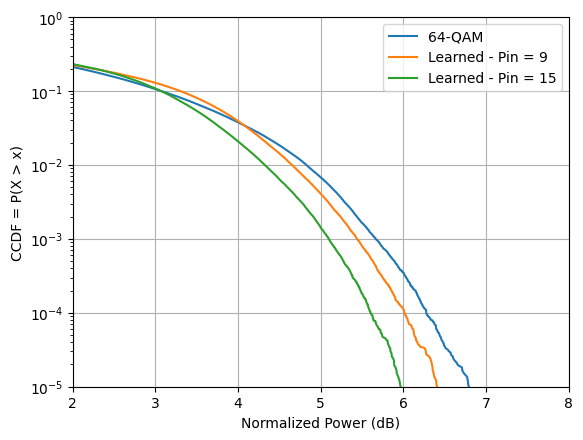

In [22]:
plt.figure()
plt.plot(x_sorted, ccdf,label="64-QAM")
plt.plot(x_sorted2, ccdf2,label="Learned - Pin = 9")
plt.plot(x_sorted3, ccdf3,label="Learned - Pin = 15")
# plt.plot(x_sorted4, ccdf4)
plt.xlabel("Normalized Power (dB)")
plt.xlim(2,8)
plt.ylabel("CCDF = P(X > x)")
plt.yscale("log")   # optional, very common
plt.grid(True)
plt.ylim(1e-5, 1)
plt.legend()
plt.show()

### ACLR Plot

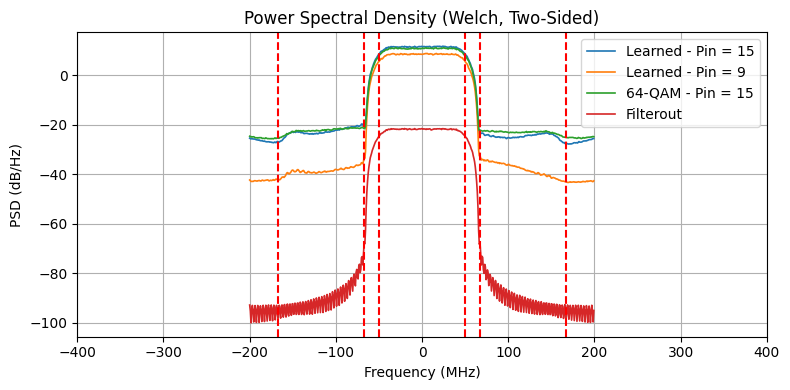

In [17]:
# Convert TensorFlow tensors → NumPy
f = f_plot.numpy()
Pxx3 = Pxx_plot3.numpy()
Pxx_filter = Pxx_filter_out.numpy()
Pxx2 = Pxx_plot2.numpy()
Pxx1 = Pxx_plot1.numpy()
# Pxx_w_dpd = Pxx_w_dpd_out.numpy()
# Convert to dB/Hz
Pxx3_dB = 10 * np.log10(np.abs(Pxx3) + 1e-30)
Pxx2_dB = 10 * np.log10(np.abs(Pxx2) + 1e-30)
Pxx1_dB = 10 * np.log10(np.abs(Pxx1) + 1e-30)
Pxx_filter_dB = 10 * np.log10(np.abs(Pxx_filter) + 1e-30)
# Pxx_w_dpd_dB = 10 * np.log10(np.abs(Pxx_w_dpd) + 1e-30)

plt.figure(figsize=(8, 4))
plt.plot(f / 1e6, Pxx3_dB, linewidth=1.2,label="Learned - Pin = 15")
plt.plot(f / 1e6, Pxx2_dB, linewidth=1.2,label="Learned - Pin = 9")
plt.plot(f / 1e6, Pxx1_dB, linewidth=1.2,label="64-QAM - Pin = 15")
plt.plot(f / 1e6, Pxx_filter_dB, linewidth=1.2,label="Filterout")
# plt.plot(f / 1e6, Pxx_w_dpd_dB, linewidth=1.2)

plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz)")
plt.xlim([-400,400])
plt.title("Power Spectral Density (Welch, Two-Sided)")

plt.axvline(x=(acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(-acpr_offsets_input[0] - meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(-acpr_offsets_input[0] + meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")

plt.axvline(x=(- meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.axvline(x=(meas_bw_main_input/2)/1e6 , linestyle = "--", color = "red")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Training Function

In [ ]:
N = 64  # Number of classes (symbols)

# # 16QAM constellation points
real_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Real part values
imag_values = [-7, -5, -3, -1, 1, 3, 5, 7]  # Imaginary part values
# # Generate the 64QAM constellation
constellation = np.array([(x + 1j * y) for x in real_values for y in imag_values])
# Compute average energy
Es = np.mean(np.abs(constellation)**2)
# Normalize
constellation = constellation / np.sqrt(Es)


snr_db = 12  # SNR in dB
# No = 1/(10**(snr_db/10))

Pin = 15

# Batch size
batch_size = 40
stream_size = 4096

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
# tf.config.run_functions_eagerly(True)

weights_file = "dpd_trained_overdrive15.weights.h5"

model = EndToEndSystem(weights_file, N, constellation, snr_db, batch_size, stream_size, Pin, use_upsampling_filtering=True, with_dpd=True)

In [8]:
for v in model.trainable_weights:
    print(v.path, v.shape)

end_to_end_system_2/modulator_2/constellation_real (64,)
end_to_end_system_2/modulator_2/constellation_imag (64,)
end_to_end_system_2/demodulator_2/dense_10/kernel (3, 128)
end_to_end_system_2/demodulator_2/dense_10/bias (128,)
end_to_end_system_2/demodulator_2/dense_11/kernel (128, 128)
end_to_end_system_2/demodulator_2/dense_11/bias (128,)
end_to_end_system_2/demodulator_2/dense_12/kernel (128, 64)
end_to_end_system_2/demodulator_2/dense_12/bias (64,)


In [14]:
###############################
# Train function
###############################
N = 64
num_bits_symbol = np.log2(N)
# constellation_orig = Constellation("pam", num_bits_per_symbol=6)
# tau = 10
# parity_k = 0
use_upsampling_filtering = True
uniform_input = True

# device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
# model = EndToEndSystem_bitwise_PAS(N, parity_k, symbol_points_qam64, device, constellation_orig, use_upsampling_filtering, uniform_input, tau)

# batch_size = 1000

# PAPR threshold is expected in dB (10log10)
# def train(sys, papr_threshold):
# papr_threshold_db = 5.0 #dB
# papr_threshold = tf.math.pow(10.0, papr_threshold_db / 10.0)

# We define a new optimizer at every rune
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Inner loop
@tf.function
def _inner_loop(step, num_it):
    # We need to initialize c...
    # excess_power = 0.0
    # c_excess_power = excess_power
    # L = 0.0

    k = tf.constant(0, tf.int32)
    while tf.less(k, num_it):
        with tf.GradientTape() as tape:
            ebno_db = tf.random.uniform(shape=[batch_size], minval=6.0, maxval=15.0)
            No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
            No = tf.expand_dims(No, axis=-1)
            # Running the system
            # print('test 1')
            # tf.print(tf.executing_eagerly())
            loss = model(No)  # 68.546 for pin 9 and 100 for Pin 15
            # print('test 2')
            # loss, loss_ordinary, entropy_value,shaping_probs, norm_C_points,_  = model(ebno_db, No)

            # if use_upsampling_filtering:
            #     powers = model.compute_power_to_average_power_samples(
            #         batch_size, 80, norm_C_points)
            #     excess_power = tf.reduce_mean(tf.nn.relu(powers[64:-64]  - papr_threshold))
            #     excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
            #     c_excess_power = excess_power - (-2.5)
            #     c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)
            #
            # else:
            #     norm_constant = tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1)
            #     powers = tf.square(tf.abs(norm_C_points))/tf.expand_dims(norm_constant, axis=1)
            #     excess_power = tf.reduce_mean(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.nn.relu(powers - papr_threshold),axis=1))
            #     excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
            #     c_excess_power = excess_power - (-2.5)
            #     c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)
            #
            # # Augmented Lagrangian
            # L = loss - lambd_papr * c_excess_power + 0.5 * mu * (
            #     tf.square(c_excess_power))

        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        grads, glob_norm = tf.clip_by_global_norm(grads, 0.1)
        optimizer.apply_gradients(zip(grads, weights))
                # Print progress
        if k % 50 == 0:
          tf.print('Iteration',k, 'loss', loss / np.log(2),'glob_norm',glob_norm)

        k = k + 1
        step = step + 1

        # if use_upsampling_filtering:
        #     norm_constant = tf.cast(tf.expand_dims(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1),axis=1),tf.complex64)
        #     norm_C_points = norm_C_points/tf.sqrt(norm_constant)
        #     powers = model.compute_power_to_average_power_samples(batch_size,80, norm_C_points)
        #     excess_power = tf.reduce_mean(tf.nn.relu(powers[64:-64] - papr_threshold))
        #     excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
        #     c_excess_power = excess_power - (-2.5)
        #     c_excess_power = tf.maximum(c_excess_power, lambd_papr / mu)
        #
        # else:
        #     norm_constant = tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.abs(norm_C_points)**2,axis=1)
        #     powers = tf.square(tf.abs(norm_C_points))/tf.expand_dims(norm_constant, axis=1)
        #     excess_power = tf.reduce_mean(tf.reduce_sum(tf.squeeze(shaping_probs, axis=2)*tf.nn.relu(powers - papr_threshold),axis=1))
        #     excess_power = tf.math.log(excess_power + 1e-12) / tf.math.log(10.)
        #     c_excess_power = excess_power - (-2.5)
        #     c_excess_power = tf.maximum(c_excess_power,lambd_papr / mu)

    return step

# Outer-loop
# Lagrange multiplier
# lambd_papr = tf.Variable(tf.constant(0.0, tf.float32), trainable=False, dtype=tf.float32)
# print(lambd_papr.shape)
# Penalty parameter
# mu = tf.Variable(0.01, trainable=False, dtype=tf.float32)

step = tf.constant(0, tf.int32)
for i in range(20):

    # Find a local minimizer (increase the first number of iterations if using random initializations)
    # if i == 0:
    #     num_it = 5000
    # else:
    #     num_it = 500
    num_it = 500
    # c_excess_power, step = _inner_loop(lambd_papr, mu, step, num_it)
    step = _inner_loop(step, num_it)
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    tf.print('Progress :',i)
    tf.print('-------------------------------------------------------')
    tf.print('-------------------------------------------------------')
    # Update Lagrange multipliers
    # tf.print('c_excess_power',c_excess_power,'lambd_papr',lambd_papr)
    # if i == 0:
    # lambd_papr = lambd_papr - mu * c_excess_power

    # Update penalty parameter
    # mu = 1.003 * mu

Iteration 0 loss 6.32701397 glob_norm 1.60167
Iteration 50 loss 5.57142258 glob_norm 0.379133135
Iteration 100 loss 4.45338726 glob_norm 0.86467725
Iteration 150 loss 3.63476086 glob_norm 0.622757375
Iteration 200 loss 3.09450364 glob_norm 0.868094146
Iteration 250 loss 2.68211031 glob_norm 0.895093918
Iteration 300 loss 2.39847469 glob_norm 0.731099188
Iteration 350 loss 2.32013512 glob_norm 1.34345269
Iteration 400 loss 2.05553389 glob_norm 0.91083324
Iteration 450 loss 1.96087492 glob_norm 1.43217874
-------------------------------------------------------
-------------------------------------------------------
Progress : 0
-------------------------------------------------------
-------------------------------------------------------
Iteration 0 loss 1.83233809 glob_norm 1.12746179
Iteration 50 loss 1.89485633 glob_norm 0.906832
Iteration 100 loss 1.58500481 glob_norm 0.865853429
Iteration 150 loss 1.63508415 glob_norm 1.09583843
Iteration 200 loss 1.61366916 glob_norm 1.5506351
Iter

KeyboardInterrupt: 

In [8]:
def plot_constellation(points, plot_title):

    points = np.asarray(points)
    # probabilities = np.asarray(probabilities).flatten()

    # Scale marker sizes for visibility
    marker_sizes = 300 #* probabilities / max(probabilities)

    plt.figure(figsize=(8, 8))
    plt.scatter(points.real, points.imag, s=marker_sizes, alpha=0.7, c='b', edgecolors='k')

    # Annotate with 6-bit binary labels
    # for i, pt in enumerate(points):
    #     label = format(i, '06b')  # 6-bit binary string
    #     plt.text(pt.real + 0.05, pt.imag + 0.05, label, fontsize=9, ha='left', va='bottom', color='darkred')

    # Add grid and formatting
    plt.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    plt.grid(True, linestyle=':')
    plt.xlabel("In-phase")
    plt.ylabel("Quadrature")
    plt.title(plot_title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    # plt.show()

[-1.1798093 -0.8006455j  -0.9636543 -0.49186775j -1.3084135 -0.34304872j
 -1.3609276 +0.08648844j -1.3108755 +0.5353592j  -0.68179524+0.3138255j
 -1.0012423 +0.26405185j -0.952914  +1.0325876j  -0.7266876 -1.1972511j
 -0.79075336-0.84022385j -0.73723227-0.28029513j -0.6614817 -0.0016209j
 -1.0101821 -0.08309767j -0.941342  +0.64681184j -0.6142158 +0.61290926j
 -0.47889185+1.3122581j  -0.43181205-0.9260508j  -0.08319542-0.9690506j
 -0.57555586-0.57975644j -0.44252416-0.2874467j  -0.25057444-0.07394433j
 -0.40364146+0.15125327j -0.3384809 +0.42674172j -0.5749943 +0.94581467j
 -0.3139415 -1.304476j    0.03275283-0.6140767j  -0.27017468-0.6390857j
 -0.13731056-0.34425282j -0.08794867+0.21147835j -0.30406147+0.73511803j
 -0.19568054+1.064375j    0.00291282+0.7989507j   0.09158194-1.3566324j
  0.22912343-0.84775174j  0.14896701-0.32203382j  0.29995352+0.00652256j
  0.03388719-0.04697979j -0.03134526+0.49607328j  0.21804586+1.0304393j
  0.02613774+1.3757575j   0.38047233-1.1430323j   0.366984

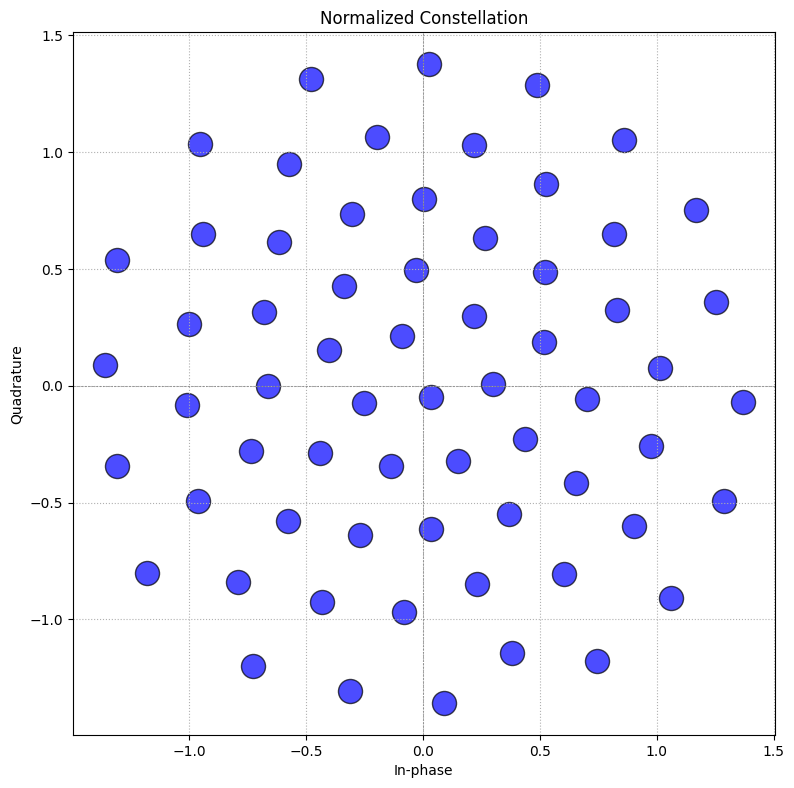

In [9]:
with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
    ebno_db = tf.random.uniform(shape=[1], minval=7.0, maxval=7.2)
    No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
    No = tf.expand_dims(No, axis=-1)
    _ = model(No)

# Define constellation points (complex numbers)
points = model.modulator.constellation_real.numpy()+ 1j*model.modulator.constellation_imag.numpy()
title_plot = f"Normalized Constellation"
# Plot the constellation
plot_constellation(points, title_plot)

print(points)


[-0.96417135-0.90932375j -1.1710488 -0.6346427j  -1.2794586 -0.33822745j
 -1.3253708 -0.02208771j -1.2932217 +0.29279736j -0.93577135+0.15050285j
 -0.8500691 +0.45021117j -1.004104  +0.8720671j  -0.4116887 -1.2644778j
 -0.61631024-0.7394535j  -0.851797  -0.50311846j -0.92294174-0.17148723j
 -0.6034097 +0.05698337j -1.1825984 +0.6031507j  -0.64522886+0.7181586j
 -0.7611477 +1.0899985j  -0.08705415-1.3428794j  -0.7081254 -1.1240065j
 -0.5978142 -0.30044883j -0.32043236-0.16397464j -0.29075277+0.16514197j
 -0.5103717 +0.40342698j -0.37555513+0.87655973j -0.47624236+1.2514814j
 -0.34588295-0.5312697j  -0.32822314-0.9091416j  -0.04272169-0.37322676j
 -0.02518123-0.02943925j  0.00794114+0.30653337j -0.22898127+0.5652439j
 -0.07217948+0.9405865j  -0.17835793+1.318971j    0.01631027-1.0177289j
 -0.03320208-0.6915368j   0.266396  -0.5621989j   0.25449046-0.21238631j
  0.28471488+0.11818743j  0.11132558+0.63556015j  0.2460508 +0.95838726j
  0.12221436+1.3331567j   0.27504808-1.3155799j   0.34226

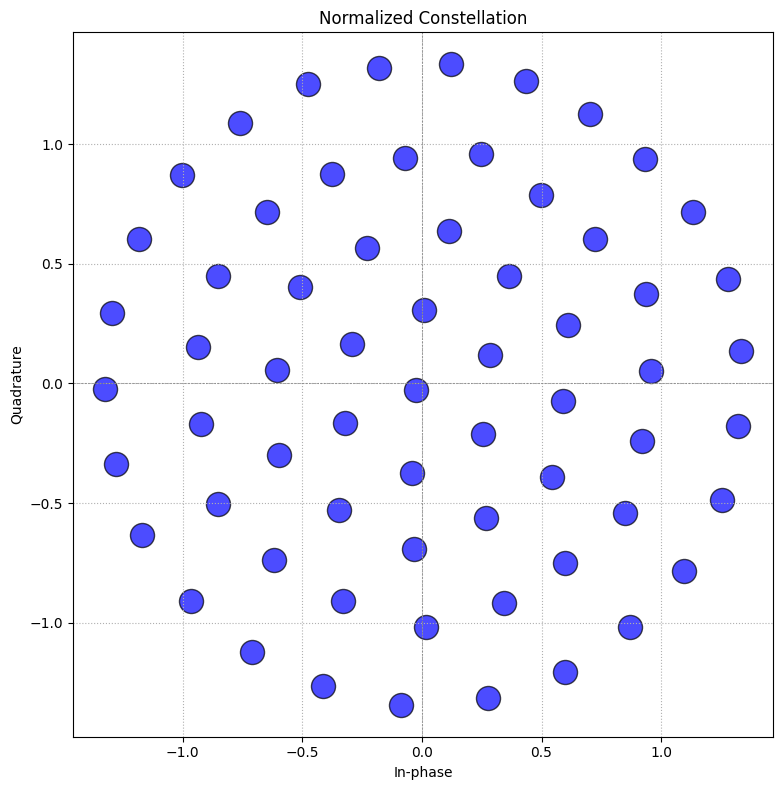

In [16]:
with tf.GradientTape(persistent=False) as tape:
#     tape.watch(model.trainable_variables)  # Ensure variables are watched if needed, but no gradients will be calculated
    ebno_db = tf.random.uniform(shape=[1], minval=7.0, maxval=7.2)
    No = sn.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=num_bits_symbol, coderate=1)
    No = tf.expand_dims(No, axis=-1)
    _ = model(No)

points = model.modulator.constellation_real.numpy()+ 1j*model.modulator.constellation_imag.numpy()
title_plot = f"Normalized Constellation"
# Plot the constellation
plot_constellation(points, title_plot)
print(points)
